In [1]:
"""
4D Temporal Time Series Model for Imputing Missing ktemp Values
Dataset columns: altitude, longitude, latitude, year_month, ktemp
MVP: Minimum Viable Prediction model using TensorFlow
"""

'\n4D Temporal Time Series Model for Imputing Missing ktemp Values\nDataset columns: altitude, longitude, latitude, year_month, ktemp\nMVP: Minimum Viable Prediction model using TensorFlow\n'

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import datetime as dt
from pathlib import Path

C:\Users\mvana\.conda\envs\MSc\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [20]:
# Current working directory (notebook folder)
notebook_path = Path.cwd()  # MLT/code/data_processing/
base_path = notebook_path.parent.parent  # Go up to MLT/

functions_path = notebook_path.parent / "000_Functions.ipynb"
bronze_path = base_path / "data" / "bronze"
silver_path = base_path / "data" / "silver"

In [4]:
# Load CSVs
df = pd.read_csv( bronze_path / "bronze_saber_4d_tempoaral_agg.csv")

In [5]:
df.columns = df.columns.str.replace('_bin', '', regex=False)

In [6]:
df['year_month'] = pd.to_datetime(df['year_month']).dt.to_period('M')

# Extract numeric features from year_month
df['year'] = df['year_month'].dt.year
df['month'] = df['year_month'].dt.month

# Sort data for temporal feature creation
df = df.sort_values(['altitude', 'latitude', 'longitude', 'year', 'month']).reset_index(drop=True)

In [7]:
# Create lag features (1 month lag)
df['ktemp_lag1'] = df.groupby(['altitude','latitude','longitude'])['ktemp'].shift(1)
df['ktemp_lag2'] = df.groupby(['altitude','latitude','longitude'])['ktemp'].shift(2)

# Fill remaining NaNs in lag features with mean of the column
df['ktemp_lag1'] = df['ktemp_lag1'].fillna(-9999)
df['ktemp_lag2'] = df['ktemp_lag2'].fillna(-9999)

# Features and target
features = ['altitude', 'longitude', 'latitude', 'year', 'month', 'ktemp_lag1', 'ktemp_lag2']
target = 'ktemp'

In [8]:
# Scale features
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

In [9]:
# Separate rows with ktemp missing and available
df_train = df[df['ktemp'].notna()]
df_missing = df[df['ktemp'].isna()]

X_train = df_train[features].values
y_train = df_train[target].values

In [10]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_tr_tf = tf.constant(X_tr, dtype=tf.float32)
X_val_tf = tf.constant(X_val, dtype=tf.float32)
y_tr_tf = tf.constant(y_tr, dtype=tf.float32)
y_val_tf = tf.constant(y_val, dtype=tf.float32)

# Create TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_tr, y_tr)).batch(32)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32)

In [14]:
def TemporalImputerModel(input_dim):
    inputs = tf.keras.Input(shape=(input_dim,))
    x = layers.Dense(64, activation="relu")(inputs)
    x = layers.Dense(32, activation="relu")(x)
    outputs = layers.Dense(1)(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model



model = TemporalImputerModel(input_dim=X_tr.shape[1])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [15]:
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [16]:
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=20,
                    callbacks=[early_stop],
                    verbose=1)

Epoch 1/20
17321/17321 ━━━━━━━━━━━━━━━━━━━━ 66s 4ms/step - loss: 715.5046 - mae: 14.7704 - val_loss: 273.5913 - val_mae: 11.2876
Epoch 2/20
17321/17321 ━━━━━━━━━━━━━━━━━━━━ 65s 4ms/step - loss: 244.1318 - mae: 10.7455 - val_loss: 223.9596 - val_mae: 10.4374
Epoch 3/20
17321/17321 ━━━━━━━━━━━━━━━━━━━━ 65s 4ms/step - loss: 220.5593 - mae: 10.3587 - val_loss: 219.0127 - val_mae: 10.3741
Epoch 4/20
17321/17321 ━━━━━━━━━━━━━━━━━━━━ 67s 4ms/step - loss: 217.7297 - mae: 10.3059 - val_loss: 217.7591 - val_mae: 10.3667
Epoch 5/20
17321/17321 ━━━━━━━━━━━━━━━━━━━━ 66s 4ms/step - loss: 214.9040 - mae: 10.2281 - val_loss: 214.8446 - val_mae: 10.2441
Epoch 6/20
17321/17321 ━━━━━━━━━━━━━━━━━━━━ 67s 4ms/step - loss: 212.3554 - mae: 10.1476 - val_loss: 213.3771 - val_mae: 10.2003
Epoch 7/20
17321/17321 ━━━━━━━━━━━━━━━━━━━━ 64s 4ms/step - loss: 211.0229 - mae: 10.1009 - val_loss: 212.3592 - val_mae: 10.1692
Epoch 8/20
17321/17321 ━━━━━━━━━━━━━━━━━━━━ 68s 4ms/step - loss: 209.7317 - mae: 10.0611 - val_lo

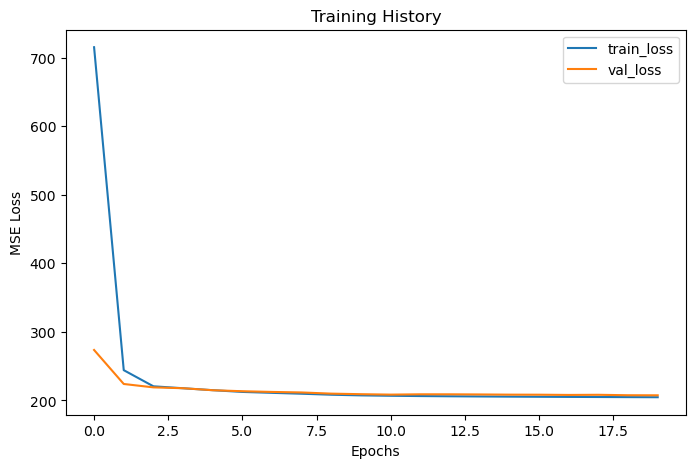

In [17]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training History')
plt.legend()
plt.show()

In [18]:
def impute_missing(df, features, model, scaler):
    df_copy = df.copy()
    
    # Scale features
    df_copy[features] = scaler.transform(df_copy[features])
    
    # Predict missing values
    mask = df_copy['ktemp'].isna()
    X_missing = df_copy.loc[mask, features].values
    df_copy.loc[mask, 'ktemp'] = model.predict(X_missing).flatten()
    
    return df_copy

df_imputed = impute_missing(df, features, model, scaler)

3677/3677 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step


In [21]:
# Ensure silver folder exists
silver_path.mkdir(parents=True, exist_ok=True)

# Define tables to save
tables = {'silver_saber_4d_tempoaral_agg':df_imputed}

for table_name, table in tables.items():
    try:
        file_path = bronze_path / f"{table_name}.csv"
        table.to_csv(file_path, index=False)
        print(f"[SUCCESS] {table_name}.csv")
    except Exception as e:
        print(f"[ERROR] Could not save {table_name}. Reason: {e}")

print("All CSVs saved successfully")

[SUCCESS] silver_saber_4d_tempoaral_agg.csv
All CSVs saved successfully
